Last tested with sklearn 1.0.2

# Model Explainability Based on Traditional Statistical Principles

In [1]:
import sklearn
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

## Load and Explore Boston Housing Data

The goal is to predict median value of owner-occupied homes in $100,000s ***AND*** to understand what influences home value.

In [2]:

from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
df = pd.DataFrame(data.data, columns=data.feature_names)
target = pd.DataFrame(data.target, columns=["MedHouseVal"])

##### View details of the data

In [3]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


A function to produce a quick summary of the columns in a dataframe

In [5]:
# input a dataframe
# returns a dataframe with helpful statistics on the dataframe and its columns
# modified for py3

def dqr(d):
    #data types
    dqr_data_types = pd.DataFrame(d.dtypes, columns=['data_type'])

    #percent missing
    dqr_percent_missing = pd.DataFrame(100*(d.isnull().sum()/len(d)).round(3), columns=['perc_missing'])

    #unique values
    dqr_unique_values = pd.DataFrame(columns=['unique_values'])
    for c in d:
        dqr_unique_values.loc[c]=d[c].nunique()
        
    #mode
    dqr_mode = pd.DataFrame(d.mode().loc[0])
    dqr_mode.rename(columns={ dqr_mode.columns[0]: "mode" }, inplace=True)
    
    #count mode
    dqr_count_mode = pd.DataFrame(columns=['count_mode'])
    for c in d:
        dqr_count_mode.loc[c]=d[c][d[c] == dqr_mode.loc[[c]].iloc[0]['mode']].count()  

    #% mode
    dqr_percent_mode = pd.DataFrame(100*(dqr_count_mode['count_mode'].values/len(d)), \
        index=dqr_count_mode.index, columns=['perc_mode'])
    
    #distribution stats    
    for i, c in enumerate(d):
        if i==0:
            dqr_stats = pd.DataFrame(d[c].describe())
        if i>0:
            dqr_stats = dqr_stats.join(pd.DataFrame(d[c].describe()))
        i=i+1
    dqr_stats=dqr_stats.transpose().drop('count', axis=1)
            
    print("# of records: ", len(d))
    print("# of columns: ", len(d.columns))
    
    done = dqr_data_types
    done['unique_values'] = dqr_unique_values['unique_values'].values
    done['perc_missing'] = dqr_percent_missing['perc_missing'].values
    done['mode'] = dqr_mode['mode'].values
    done['perc_mode'] = dqr_percent_mode['perc_mode'].values
    done = done.join(dqr_stats)
    
    return done

In [6]:
dqr(target)

# of records:  20640
# of columns:  1


,data_type,unique_values,perc_missing,mode,perc_mode,mean,std,min,25%,50%,75%,max
MedHouseVal,float64,3842,0.0,5.00001,4.675388,2.068558,1.153956,0.14999,1.196,1.797,2.64725,5.00001


In [7]:
dqr(df)

# of records:  20640
# of columns:  8


,data_type,unique_values,perc_missing,mode,perc_mode,mean,std,min,25%,50%,75%,max
MedInc,float64,12928,0.0,3.125,0.237403,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,float64,52,0.0,52.000,6.167636,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,float64,19392,0.0,5.000,0.130814,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,float64,14233,0.0,1.000,1.395349,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,float64,3888,0.0,891.000,0.121124,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,float64,18841,0.0,3.000,0.169574,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,float64,862,0.0,34.060,1.182171,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,float64,844,0.0,-118.310,0.784884,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000


## Global Explainability via a Linear Model

Global explainability can be obtained from a linear model through an analysis of the coefficients.

Before doing this, certain requirements must be satisfied.

1. Linearity: The relationship between X and the mean of Y is linear.
2. Homoscedasticity: The variance of residual is the same for any value of X.
3. Independence: Observations are independent of each other.
4. Normality: For any fixed value of X, Y is normally distributed.

Additionally, when data is not on a common scale then differences in measurment scales can adversly affect prediction and interpretation.

### Prepare data for interpretation via a linear model

#### Standardize, center, or otherwise put the data on a common scale

Here we standardize the data

In [8]:
# sklearn has a nice approach that allows for the saving of the trasformation parameters for later use
# however this is easier to do once with pandas
df_stnd=(df-df.mean())/df.std()
df_stnd.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.344709,0.982119,0.628544,-0.153754,-0.974405,-0.049595,1.052523,-1.327803
1,2.332181,-0.607004,0.327033,-0.263329,0.861418,-0.092510,1.043159,-1.322812
2,1.782656,1.856137,1.155592,-0.049015,-0.820757,-0.025842,1.038478,-1.332794
3,0.932945,1.856137,0.156962,-0.049832,-0.766010,-0.050328,1.038478,-1.337785
4,-0.012881,1.856137,0.344702,-0.032905,-0.759828,-0.085614,1.038478,-1.337785


#### Check for multicolinearity

Multicolinearity affects several of the model assumptions. This doesn't hinder prediction, but it can make interpretation of coefficients misleading. Multicolinearity can be checked graphically (e.g. with a scatterplot matrix) and statistically (e.g. with Variance Inflation Factor or the Condition Number Test).

Correlation Matrix

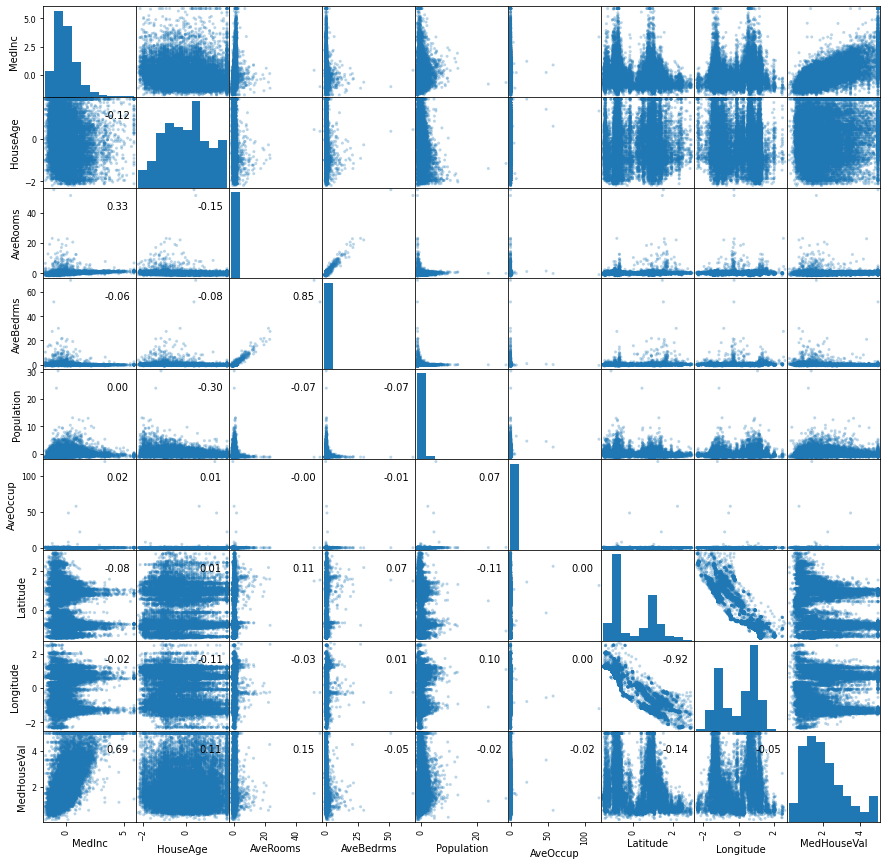

In [9]:
df_stnd
from pandas.plotting import scatter_matrix
axes = scatter_matrix(df_stnd.join(target), alpha=0.3, figsize=(15, 15), diagonal='hist')
corr = df_stnd.join(target).corr().values
for i, j in zip(*plt.np.tril_indices_from(axes, k=-1)):
    axes[i, j].annotate("%.2f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

X-matrix Condition Number (>30 is often considered cause for concern and points to multicolinearity or other matrix issues)

In [10]:
np.linalg.cond(df_stnd.values)

6.668219383861402

As a reference, here is the Condition Number before centering/standardizing

In [11]:
np.linalg.cond(df.values)

10310.017246910393

In [12]:
df_stnd

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.344709,0.982119,0.628544,-0.153754,-0.974405,-0.049595,1.052523,-1.327803
1,2.332181,-0.607004,0.327033,-0.263329,0.861418,-0.092510,1.043159,-1.322812
2,1.782656,1.856137,1.155592,-0.049015,-0.820757,-0.025842,1.038478,-1.332794
3,0.932945,1.856137,0.156962,-0.049832,-0.766010,-0.050328,1.038478,-1.337785
4,-0.012881,1.856137,0.344702,-0.032905,-0.759828,-0.085614,1.038478,-1.337785
...,...,...,...,...,...,...,...,...
20635,-1.216099,-0.289180,-0.155020,0.077352,-0.512579,-0.049109,1.801603,-0.758808
20636,-0.691576,-0.845373,0.276874,0.462353,-0.944382,0.005021,1.806285,-0.818702
20637,-1.142566,-0.924829,-0.090316,0.049413,-0.369528,-0.071733,1.778194,-0.823693
20638,-1.054557,-0.845373,-0.040210,0.158774,-0.604415,-0.091223,1.778194,-0.873605


At this point, subject matter expertise and a bit of art comes into play as there appears to be some multicolinearity in the data.

Drop AveBedrms as it is highly correlated with AveRooms and Latitude and Longitude as they are arbitrary 

In [13]:
df_stnd.drop(['AveBedrms', 'Longitude', 'Latitude'], axis=1, inplace=True)

After PCA, the correlation matrix and Condition Number look much better

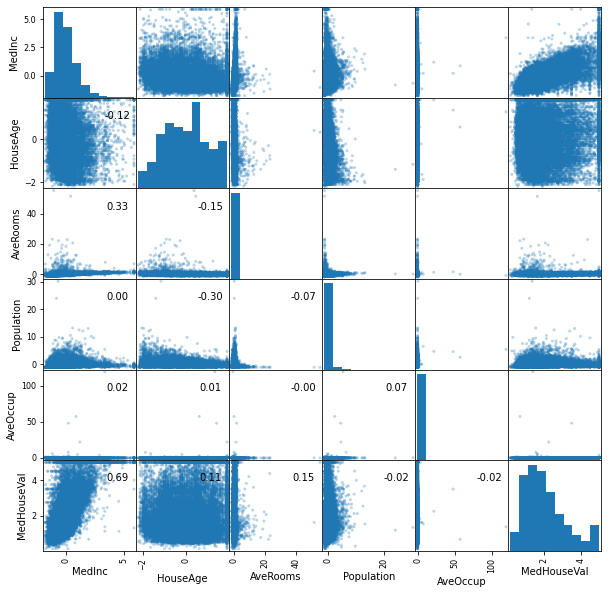

In [14]:
from pandas.plotting import scatter_matrix
axes = scatter_matrix(df_stnd.join(target), alpha=0.3, figsize=(10, 10), diagonal='hist')
corr = df_stnd.join(target).corr().values
for i, j in zip(*plt.np.tril_indices_from(axes, k=-1)):
    axes[i, j].annotate("%.2f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

In [15]:
np.linalg.cond(df_stnd.values)


1.5374346306255486

### Build the linear model

In [16]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_stnd.values,target.values, test_size=0.15)
X_train = pd.DataFrame(X_train, columns=df_stnd.columns)
y_train = pd.DataFrame(y_train, columns=target.columns)
X_test = pd.DataFrame(X_test, columns=df_stnd.columns)
y_test = pd.DataFrame(y_test, columns=target.columns)

In [17]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MedHouseVal   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     3698.
Date:                Tue, 13 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:10:50   Log-Likelihood:                -21063.
No. Observations:               17544   AIC:                         4.214e+04
Df Residuals:                   17538   BIC:                         4.219e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0691      0.006    340.860      0.000       2.057       2.081
MedInc         0.8354      0.006    130.717      0.000       0.823       0.848
HouseAge       0.2193      0.006     33.935      0.000       0.207       0.232
AveRooms      -0.0590      0.006     -9.472      0.000      -0.071      -0.047
Population     0.0314      0.006      4.894      0.000       0.019       0.044
AveOccup      -0.0454      0.006     -8.080      0.000      -0.056      -0.034
==============================================================================
Omnibus:                     3796.486   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10010.619
Skew:                           1.169   Prob(JB):                         0.00
Kurtosis:                       5.869   Cond. No.                         1.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RMSE for accuracy

In [18]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
res_test = y_pred_test - y_test.MedHouseVal.values
res_train = y_pred_train - y_train.MedHouseVal.values

In [19]:
rmse_lin = np.sqrt(np.sum((res_test*res_test))/np.size(res_test))
print('RMSE', rmse_lin)

RMSE 0.8057861233195663


#### Residual Analysis

Before we can interpret the coefficients, we need to complete our assessment of the linear model assumptions by checking to see if the residuals are normally distributed (hist, normality test, and q-q plot) and free from heteroskedasticity (no spread in the pred by res plot).

Histogram and Normality test

NormaltestResult(statistic=3796.4862287775322, pvalue=0.0)


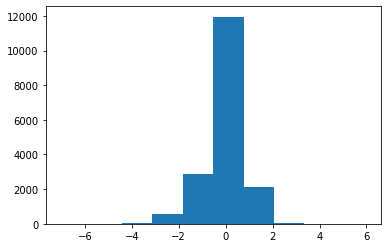

In [20]:
plt.hist(res_train)
from scipy import stats
print(stats.normaltest(res_train))

qqplot

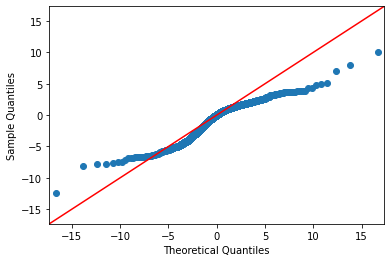

In [21]:
import scipy.stats as stats
fig = sm.qqplot(res_train, stats.t, fit=True, line='45')

pred by resid plot

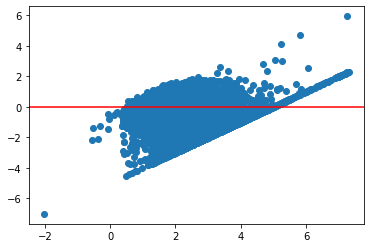

In [22]:
plt.scatter(y_pred_train, res_train)
plt.axhline(y=0, color='r', linestyle='-')

try to transform the y column 

### Coefficient Analysis

Since we have fit a linear model and validated (at least we tried - there are known issues with this dataset) the assumptions of a linear model, we can now conduct an analysis of the coefficients.

Frist, get the coefficient table into a dataframe

In [23]:
df_coeffs = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]
df_coeffs.drop(['const'], inplace=True) #drop the intercept

Next, find the minimum absolute value effect size for each variable based on 95% confidence

In [24]:
min95effect = []
for i, c in enumerate(df_coeffs.coef.values):
    if c == 0:
        min95effect.append(0)
    elif (df_coeffs['[0.025'].values[i] * df_coeffs['0.975]'].values[i]) < 0: #opposit signs
        min95effect.append(0)
    elif c < 0:
        min95effect.append(np.abs(df_coeffs['0.975]'].values[i]))
    elif c > 0:
        min95effect.append(np.abs(df_coeffs['[0.025'].values[i]))
    else:
        min95effect.append(99999)    
min95effect

[0.823, 0.207, 0.047, 0.019, 0.034]

Finalize the coefficients dataframe, sorting by the minimum absolute effect size under a 95% CI

In [25]:
df_coeffs['absmineffect'] = min95effect
df_coeffs.sort_values(['absmineffect'], ascending=False, inplace=True)
df_coeffs

,coef,std err,t,P>|t|,[0.025,0.975],absmineffect
MedInc,0.8354,0.006,130.717,0.0,0.823,0.848,0.823
HouseAge,0.2193,0.006,33.935,0.0,0.207,0.232,0.207
AveRooms,-0.0590,0.006,-9.472,0.0,-0.071,-0.047,0.047
AveOccup,-0.0454,0.006,-8.080,0.0,-0.056,-0.034,0.034
Population,0.0314,0.006,4.894,0.0,0.019,0.044,0.019


#### Interpret the coefficients 

-----Note that each new run's results may be slightly different due to the random train and test partition-----

Since the data has been scaled by it's stdev, we say that on average a one-stdev increase in MedInc (Median Income) will result in a 83,000 dollar increase in median house price *while holding the effect of all other variables in the study constant*. With 95 perc confidence we can say that the increase will be no less than 82,700 dollars. 

Similarly, for HouseAge, we find that a one stdev increase in the age of the house ratio will correspond with a 22,290 dollar decrease in median house price (at least 21,000 dollar decrease with 95 perc confidence) while holding the effect of all other variables constant. 

One can easily calculate the stdev for each variable to put this even more into a real world context.

***This is a powerful global explainability statement!***

Further we have sorted the variables by their lowest effect magnitude under 95 perc confidence so the table represents a variable importance table. We graph it below.

<!-- Finally, note that we cannot make any explainability statements about the variables in the NBH cluster, other than saying that collectively they represent at least a 1.2K dollar influence for every stdev change in their values. That is the price we have to pay in order to have a well specified model which allows us to confidently interpret at least some of the predictors. -->

Build the variable importance graph

In [26]:
mask1 = df_coeffs.coef.values < 0
colors = np.array(['Blue']*len(df_coeffs))
colors[mask1] = 'r'

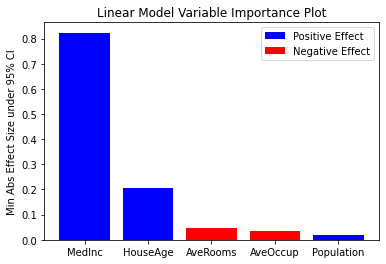

In [27]:
x=[0]
y=[0]
plt.bar(df_coeffs.index, df_coeffs.absmineffect, color = colors, label = 'Positive Effect')
plt.bar(x, y, color='red', label = 'Negative Effect') #just for the label
plt.title('Linear Model Variable Importance Plot')
plt.ylabel('Min Abs Effect Size under 95% CI')
plt.legend()

## Use a Black Box Approach with PDPs and Variable Importance

Build a gradient boosting model

In [28]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_stnd.values,target.values)
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GBR usually gives better prediction accuracy but less stable explainability.

In [29]:
y_pred = gbr.predict(X_test)
res = y_pred - y_test

This data lends itself well to a linear model. GBR overfits.

In [30]:
rmse_gbr = np.sqrt(np.sum((res*res))/np.size(res))
print('RMSE Lin', rmse_lin)
print('RMSE GBR', rmse_gbr)

RMSE Lin 0.8057861233195663
RMSE GBR 1.5068506497779899


#### Traditional Var Imp Plots

If one believes that the linear model was a better fit (and the RMSE suggests such), then we can compare the var imp graphs below to that of the linear model above and note the kind of interpretation errors that we can get if we rely too heavily on GBR, and similar, var imp metrics. Still this is all based on many assumptions. It's good to compare to SHAP var imp plots as well.

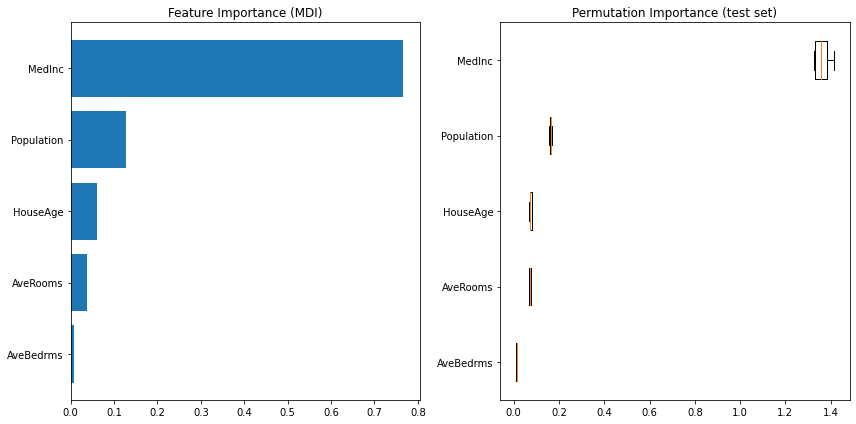

In [31]:
from sklearn.inspection import permutation_importance

feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(df.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(gbr, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(df.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
# plt.show()

#### PDP

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


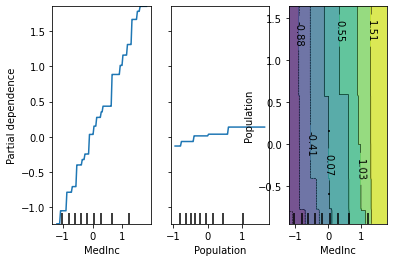

In [32]:
from sklearn.inspection import plot_partial_dependence

features = [0, 3, (0, 3)]
plot_partial_dependence(gbr, df_stnd, features) 

### ICE Plots

Individual Conditional Expectation (ICE) plots display one line per instance that shows how the instance's prediction changes when a feature changes.

##### install pycebox if needed

In [33]:
pip install pycebox

  Created wheel for pycebox: filename=pycebox-0.0.1-py3-none-any.whl size=3640 sha256=32e8f29b3f1e8a60f17b8573515ba6968adde28f118d64fd6dfcc6e2bb4e3523
  Stored in directory: /home/ubuntu/.cache/pip/wheels/57/1d/11/7ff48510e0a4cc2caea58c2e4a69545ecb452c46f24fa101ae
Successfully built pycebox
Note: you may need to restart the kernel to use updated packages.


In [34]:
from matplotlib.cm import PuOr
import scipy as sp
import seaborn as sns

from pycebox.ice import ice, ice_plot

In [35]:
ice_df = ice(df_stnd, 'MedInc', gbr.predict, num_grid_points=100)

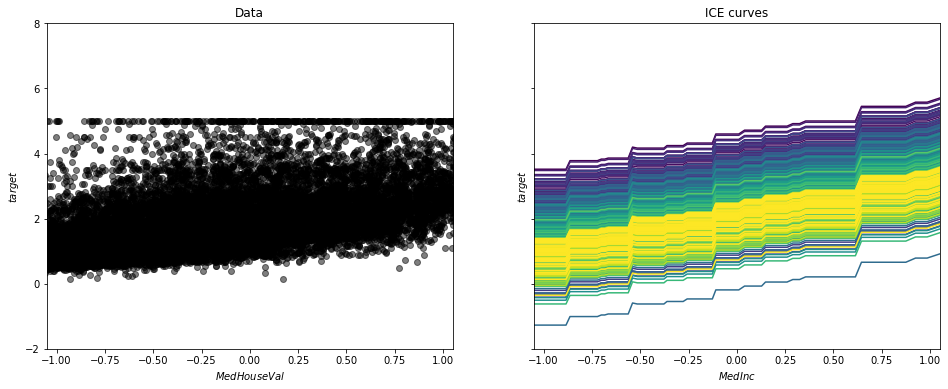

In [36]:
fig, (data_ax, ice_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

data_ax.scatter(df_stnd.MedInc.values, target.values, c='k', alpha=0.5);

data_ax.set_xlim(-1.05, 1.05);
data_ax.set_xlabel('$MedHouseVal$');

data_ax.set_ylabel('$target$');

data_ax.set_title('Data');

# ice_plot(ice_df, frac_to_plot=1,
#          c='k', alpha=0.25,
#          ax=ice_ax);

ice_plot(ice_df, frac_to_plot=1, color_by='data_MedInc', #cmap=PuOr,
         ax=ice_ax);

ice_ax.set_xlabel('$MedInc$');

ice_ax.set_ylabel('$target$');

ice_ax.set_title('ICE curves');